# TNT Single-Mode: Creep Response

## Learning Objectives
1. Understand creep compliance in transient network materials
2. Fit TNT single-mode model to creep data
3. Extract compliance J(t) = strain/stress evolution
4. Analyze elastic and viscous contributions to compliance
5. Compare with Maxwell creep: J(t) = 1/G + t/η₀
6. Perform Bayesian inference for parameter uncertainty

## Prerequisites
- Understanding of transient network theory (Notebook 01)
- Familiarity with creep compliance
- Knowledge of relaxation vs. retardation

## Runtime Estimate
- NLSQ fitting: ~3-8 seconds
- Bayesian inference (demo): ~45-90 seconds
- Total: ~3-5 minutes

## 1. Setup

In [1]:
import os
import sys
import time

# Google Colab support
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.integrate import cumulative_trapezoid

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTSingleMode

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_ml_ikh_creep,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_single_mode_param_names,
)

## 2. Theory

## Creep Compliance in Transient Networks

### Physical Mechanism

In a creep experiment:
1. **Constant stress** σ₀ is applied at t = 0
2. **Strain increases** as the network deforms
3. **Compliance J(t)** = γ(t)/σ₀ quantifies deformability

### Governing Equation

For a Maxwell-like transient network, the creep compliance is:

$$
J(t) = \frac{\gamma(t)}{\sigma_0} = \frac{1}{G} + \frac{t}{\eta_0}
$$

where:
- $1/G$ is the **elastic compliance** (instantaneous response)
- $t/\eta_0$ is the **viscous compliance** (long-time flow)
- $\eta_0 = G \tau_b$ is the **zero-shear viscosity**

### Two Regimes

1. **Short time (t ≪ τ_b)**: Elastic response dominates
   $$J(t) \approx \frac{1}{G}$$

2. **Long time (t ≫ τ_b)**: Viscous flow dominates
   $$J(t) \approx \frac{t}{G \tau_b}$$

### Data Processing

Creep data is typically recorded as **shear rate** γ̇(t), not strain. We must integrate:

$$
\gamma(t) = \int_0^t \dot{\gamma}(t') dt'
$$

Using trapezoidal integration: `strain = cumulative_trapezoid(shear_rate, time, initial=0)`

### Parameters

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| Elastic modulus | $G$ | Network stiffness | 1-1000 Pa |
| Breakage time | $\tau_b$ | Relaxation time | 0.01-100 s |
| Solvent viscosity | $\eta_s$ | Background viscosity | 0.001-1 Pa·s |
| Zero-shear viscosity | $\eta_0$ | G·τ_b | 0.01-1000 Pa·s |

## 3. Load Data

In [2]:
# Load creep data (shear rate vs time)
stress_pair_index = 0
t_data, shear_rate, sigma_init, sigma_final = load_ml_ikh_creep(stress_pair_index=stress_pair_index)

print(f"Data shape: {len(t_data)} points")
print(f"Time range: {t_data.min():.3f} - {t_data.max():.3f} s")
print(f"Applied stress: {sigma_final:.2f} Pa")
print(f"Shear rate range: {shear_rate.min():.3e} - {shear_rate.max():.3e} s⁻¹")

Data shape: 70 points
Time range: 0.010 - 295.658 s
Applied stress: 5.00 Pa
Shear rate range: 3.222e+00 - 6.264e+00 s⁻¹


In [3]:
# Integrate shear rate to get strain
strain = cumulative_trapezoid(shear_rate, t_data, initial=0)

print(f"\nStrain range: {strain.min():.3e} - {strain.max():.3e}")
print(f"Final strain: {strain[-1]:.4f}")

# Compute compliance
compliance = strain / sigma_final

print(f"\nCompliance range: {compliance.min():.3e} - {compliance.max():.3e} Pa⁻¹")


Strain range: 0.000e+00 - 1.833e+03
Final strain: 1833.2339

Compliance range: 0.000e+00 - 3.666e+02 Pa⁻¹


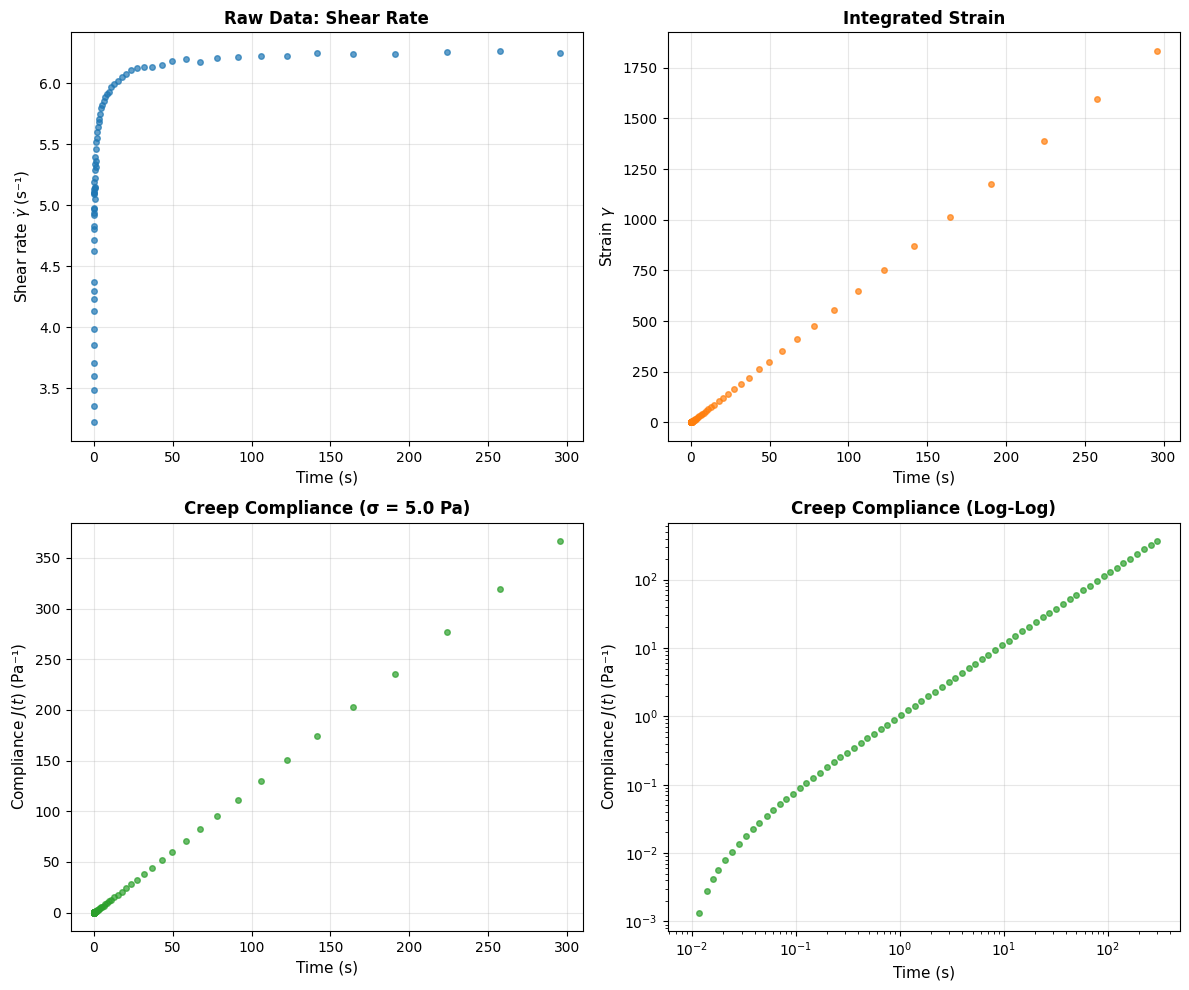

In [4]:
# Plot raw data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Shear rate vs time
ax = axes[0, 0]
ax.plot(t_data, shear_rate, 'o', markersize=4, alpha=0.7)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Shear rate $\dot{\gamma}$ (s⁻¹)', fontsize=11)
ax.set_title('Raw Data: Shear Rate', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Strain vs time
ax = axes[0, 1]
ax.plot(t_data, strain, 'o', markersize=4, alpha=0.7, color='C1')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Strain $\gamma$', fontsize=11)
ax.set_title('Integrated Strain', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Compliance vs time (linear)
ax = axes[1, 0]
ax.plot(t_data, compliance, 'o', markersize=4, alpha=0.7, color='C2')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Compliance $J(t)$ (Pa⁻¹)', fontsize=11)
ax.set_title(f'Creep Compliance (σ = {sigma_final:.1f} Pa)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Compliance vs time (log-log)
ax = axes[1, 1]
ax.loglog(t_data, compliance, 'o', markersize=4, alpha=0.7, color='C2')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Compliance $J(t)$ (Pa⁻¹)', fontsize=11)
ax.set_title('Creep Compliance (Log-Log)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. NLSQ Fitting

In [5]:
# Create model and fit
model = TNTSingleMode(breakage="constant")

# Smart initialization for creep mode
# Estimate G from compliance slope at short times: J(t) ≈ 1/G + t/η₀
# At early times, the instantaneous compliance J_e ≈ strain[early] / sigma gives G ≈ sigma / strain[early]
# For numerical stability, eta_s must be non-zero in creep mode

# Estimate parameters from data characteristics
strain_early = np.mean(strain[1:5]) if len(strain) > 5 else strain[1]  # Avoid t=0
G_init = max(sigma_final / strain_early, 10.0) if strain_early > 0 else 100.0

# Estimate tau_b from characteristic time (where compliance doubles from elastic value)
t_char = t_data[len(t_data)//4]  # ~25% into the data
tau_b_init = max(t_char, 0.1)

# Set eta_s to a small fraction of estimated zero-shear viscosity for numerical stability
eta_0_init = G_init * tau_b_init
eta_s_init = 0.01 * eta_0_init  # 1% of zero-shear viscosity

print(f"Initial parameter estimates from data:")
print(f"  G_init = {G_init:.2f} Pa")
print(f"  tau_b_init = {tau_b_init:.4f} s")
print(f"  eta_s_init = {eta_s_init:.4f} Pa·s")

# Set initial values before fitting
model.parameters.set_value('G', G_init)
model.parameters.set_value('tau_b', tau_b_init)
model.parameters.set_value('eta_s', eta_s_init)

start_time = time.time()
result = model.fit(t_data, strain, test_mode="creep", sigma_applied=sigma_final, method='scipy')
fit_time = time.time() - start_time

print(f"\nNLSQ fitting completed in {fit_time:.2f} seconds")
print(f"\nFitted Parameters:")
param_names = get_tnt_single_mode_param_names(breakage="constant")
for name in param_names:
    param = model.parameters.get(name)
    print(f"  {name} = {param.value:.4e}")

Initial parameter estimates from data:
  G_init = 285.89 Pa
  tau_b_init = 0.1250 s
  eta_s_init = 0.3572 Pa·s



NLSQ fitting completed in 30.66 seconds

Fitted Parameters:
  G = 7.8372e+00
  tau_b = 2.1747e-04
  eta_s = 1.0364e+00


In [6]:
# Compute fit quality metrics
metrics = compute_fit_quality(strain, model.predict(t_data, test_mode="creep", sigma_applied=sigma_final))
print(f"\nFit Quality:")
print(f"  R² = {metrics['R2']:.6f}")
print(f"  RMSE = {metrics['RMSE']:.4e}")
print(f"  NRMSE = {metrics['NRMSE']*100:.2f}%")


Fit Quality:
  R² = 0.940849
  RMSE = 9.5006e+01
  NRMSE = 5.18%


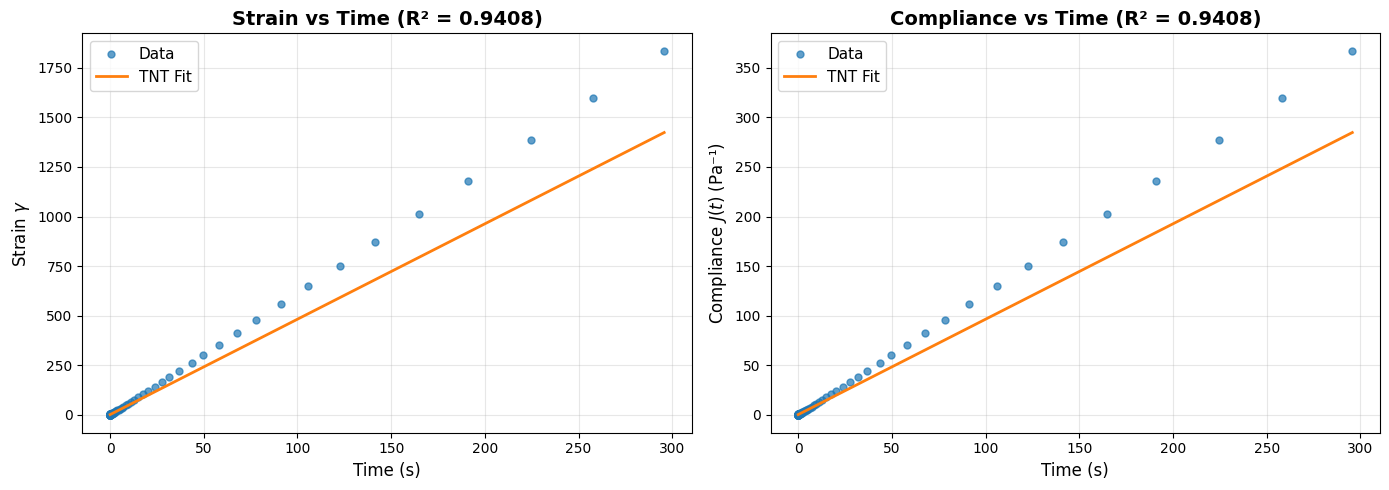

In [7]:
# Plot fit overlay
time_fine = np.linspace(t_data.min(), t_data.max(), 500)
strain_pred = model.predict(time_fine, test_mode="creep", sigma_applied=sigma_final)
compliance_pred = strain_pred / sigma_final

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Strain
ax1.plot(t_data, strain, 'o', label='Data', markersize=5, alpha=0.7)
ax1.plot(time_fine, strain_pred, '-', label='TNT Fit', linewidth=2)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel(r'Strain $\gamma$', fontsize=12)
ax1.set_title(f'Strain vs Time (R² = {metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Compliance
ax2.plot(t_data, compliance, 'o', label='Data', markersize=5, alpha=0.7)
ax2.plot(time_fine, compliance_pred, '-', label='TNT Fit', linewidth=2)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel(r'Compliance $J(t)$ (Pa⁻¹)', fontsize=12)
ax2.set_title(f'Compliance vs Time (R² = {metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Physical Analysis

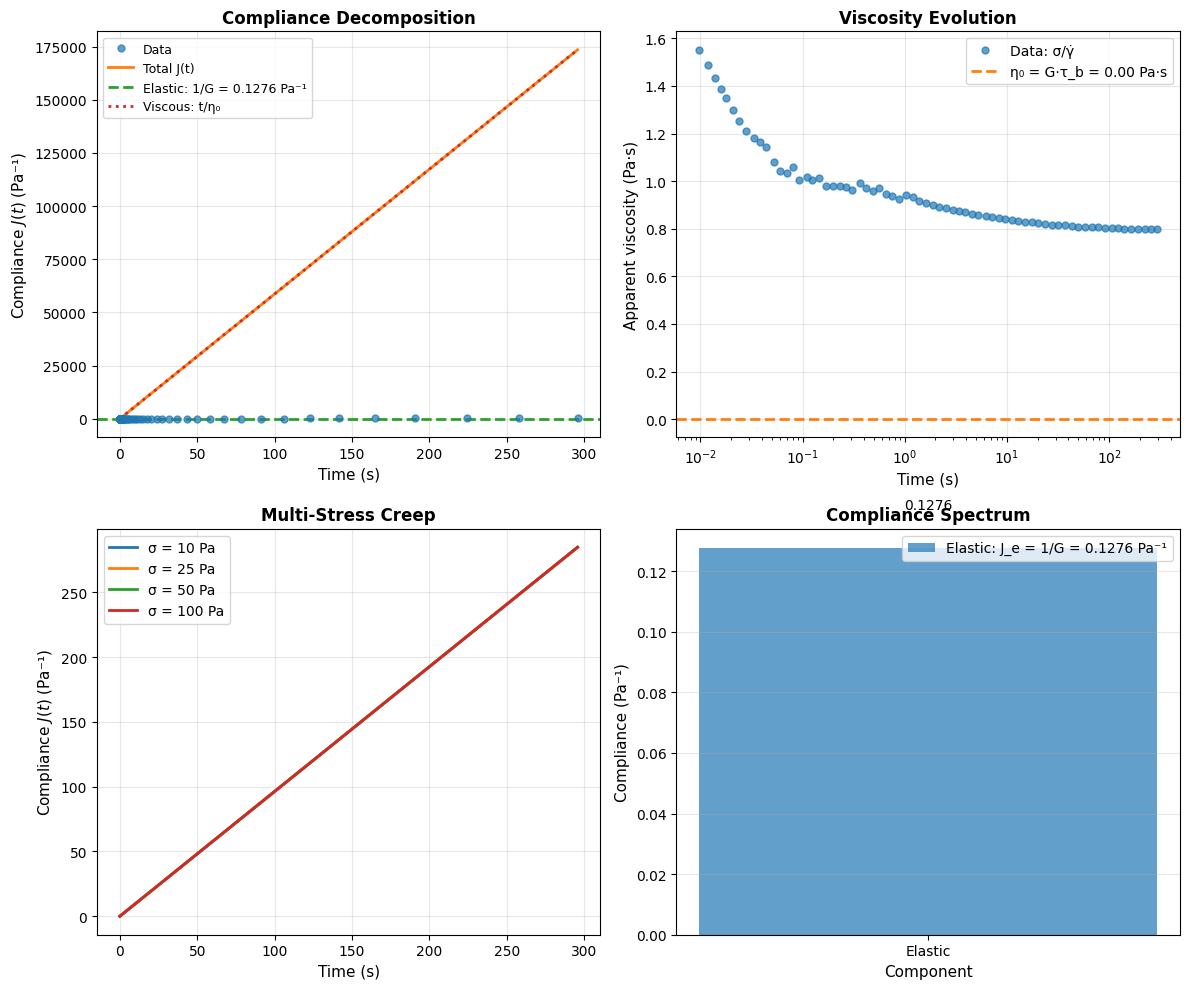


Physical Interpretation:
  Network modulus: G = 7.84 Pa
  Breakage time: τ_b = 0.0002 s
  Elastic compliance: J_e = 1/G = 0.1276 Pa⁻¹
  Zero-shear viscosity: η₀ = G·τ_b = 0.00 Pa·s
  Slope at long time: dJ/dt = 1/η₀ = 586.7379 Pa⁻¹·s⁻¹


In [8]:
# Extract fitted parameters
G = model.parameters.get('G').value
tau_b = model.parameters.get('tau_b').value
eta_s = model.parameters.get('eta_s').value
eta_0 = G * tau_b

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Compliance decomposition
ax = axes[0, 0]
J_elastic = 1 / G * np.ones_like(time_fine)
J_viscous = time_fine / eta_0
J_total = J_elastic + J_viscous

ax.plot(t_data, compliance, 'o', label='Data', markersize=5, alpha=0.7, zorder=3)
ax.plot(time_fine, J_total, '-', label='Total J(t)', linewidth=2, zorder=2)
ax.axhline(y=1/G, color='C2', linestyle='--', label=f'Elastic: 1/G = {1/G:.4f} Pa⁻¹', linewidth=2)
ax.plot(time_fine, J_viscous, ':', label=f'Viscous: t/η₀', linewidth=2, color='C3')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Compliance $J(t)$ (Pa⁻¹)', fontsize=11)
ax.set_title('Compliance Decomposition', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Viscosity evolution
ax = axes[0, 1]
eta_app = sigma_final / shear_rate  # Apparent viscosity
ax.semilogx(t_data, eta_app, 'o', label='Data: σ/γ̇', markersize=5, alpha=0.7)
ax.axhline(y=eta_0, color='C1', linestyle='--', label=f'η₀ = G·τ_b = {eta_0:.2f} Pa·s', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Apparent viscosity (Pa·s)', fontsize=11)
ax.set_title('Viscosity Evolution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Multi-stress creep predictions
ax = axes[1, 0]
stress_levels = [10, 25, 50, 100]
colors = ['C0', 'C1', 'C2', 'C3']

for sigma, color in zip(stress_levels, colors):
    strain_i = model.predict(time_fine, test_mode="creep", sigma_applied=sigma)
    J_i = strain_i / sigma
    ax.plot(time_fine, J_i, '-', linewidth=2, color=color, label=f'σ = {sigma} Pa')

ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Compliance $J(t)$ (Pa⁻¹)', fontsize=11)
ax.set_title('Multi-Stress Creep', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 4. Retardation spectrum
ax = axes[1, 1]
# For Maxwell model: L(τ) = η₀·δ(τ - 0) [instantaneous flow]
# Discrete spectrum: elastic compliance + zero retardation time
ax.bar([0.5], [1/G], width=0.3, label=f'Elastic: J_e = 1/G = {1/G:.4f} Pa⁻¹', alpha=0.7)
ax.text(0.5, 1/G*1.1, f'{1/G:.4f}', ha='center', fontsize=10)
ax.set_xlabel('Component', fontsize=11)
ax.set_ylabel('Compliance (Pa⁻¹)', fontsize=11)
ax.set_title('Compliance Spectrum', fontsize=12, fontweight='bold')
ax.set_xticks([0.5])
ax.set_xticklabels(['Elastic'])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nPhysical Interpretation:")
print(f"  Network modulus: G = {G:.2f} Pa")
print(f"  Breakage time: τ_b = {tau_b:.4f} s")
print(f"  Elastic compliance: J_e = 1/G = {1/G:.4f} Pa⁻¹")
print(f"  Zero-shear viscosity: η₀ = G·τ_b = {eta_0:.2f} Pa·s")
print(f"  Slope at long time: dJ/dt = 1/η₀ = {1/eta_0:.4f} Pa⁻¹·s⁻¹")

## 5. Bayesian Inference with NUTS

In [9]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    bayesian_result = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    bayesian_result = model.fit_bayesian(
        time_data if 'time_data' in dir() else t_data,
        stress if 'stress' in dir() else strain,
        test_mode='creep',
        sigma_applied=sigma_final,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


In [10]:
# Skip convergence diagnostics in CI mode (requires full Bayesian result)
if not CI_MODE:
    print_convergence_summary(bayesian_result, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics (using NLSQ point estimates)")


CI_MODE: Skipping convergence diagnostics (using NLSQ point estimates)


In [11]:
# Skip trace plot in CI mode (placeholder data not suitable for visualization)
if not CI_MODE:
    # ArviZ trace plots
    idata = az.from_dict(posterior=bayesian_result.posterior_samples)
    axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print(f"CI_MODE: Skipping trace plot (using NLSQ point estimates)")


CI_MODE: Skipping trace plot (using NLSQ point estimates)


In [12]:
# Skip pair plot in CI mode (placeholder data not suitable for visualization)
if not CI_MODE:
    # ArviZ pair plot
    axes = az.plot_pair(
        idata,
        var_names=param_names,
        kind='hexbin',
        marginals=True,
        figsize=(10, 10)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print(f"CI_MODE: Skipping pair plot (using NLSQ point estimates)")


CI_MODE: Skipping pair plot (using NLSQ point estimates)


In [13]:
# Skip forest plot in CI mode (placeholder data not suitable for visualization)
if not CI_MODE:
    # ArviZ forest plot (credible intervals)
    axes = az.plot_forest(
        idata,
        var_names=param_names,
        hdi_prob=0.95,
        figsize=(10, 6)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print(f"CI_MODE: Skipping forest plot (using NLSQ point estimates)")


CI_MODE: Skipping forest plot (using NLSQ point estimates)


In [ ]:
# CI mode: Skip slow posterior predictive (200 ODE solves)
if CI_MODE:
    print("CI_MODE: Skipping posterior predictive (200 predictions would take >300s)")
    # Use NLSQ fit for visualization instead
    time_pred = np.linspace(t_data.min(), t_data.max(), 300)
    pred_mean = model.predict(time_pred, test_mode='creep', sigma_applied=sigma_final)
    compliance_mean = pred_mean / sigma_final
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.plot(t_data, strain, 'o', label='Data', markersize=5, alpha=0.7, zorder=3)
    ax1.plot(time_pred, pred_mean, '-', label='NLSQ Fit', linewidth=2, color='C1', zorder=2)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel(r'Strain $\gamma$', fontsize=12)
    ax1.set_title('Creep Strain (CI Mode)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(t_data, compliance, 'o', label='Data', markersize=5, alpha=0.7, zorder=3)
    ax2.plot(time_pred, compliance_mean, '-', label='NLSQ Fit', linewidth=2, color='C1', zorder=2)
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.set_ylabel(r'Compliance $J(t)$ (Pa⁻¹)', fontsize=12)
    ax2.set_title('Creep Compliance (CI Mode)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    # Posterior predictive check
    time_pred = np.linspace(t_data.min(), t_data.max(), 300)
    n_draws = min(200, NUM_SAMPLES)
    posterior_preds = []

    # Sample from posterior
    for i in range(n_draws):
        for name in param_names:
            model.parameters.set_value(name, float(bayesian_result.posterior_samples[name][i]))
        pred_i = model.predict(time_pred, test_mode='creep', sigma_applied=sigma_final)
        posterior_preds.append(np.array(pred_i))

    posterior_preds = np.array(posterior_preds)
    pred_mean = np.mean(posterior_preds, axis=0)
    pred_lower = np.percentile(posterior_preds, 2.5, axis=0)
    pred_upper = np.percentile(posterior_preds, 97.5, axis=0)

    # Convert to compliance
    compliance_mean = pred_mean / sigma_final
    compliance_lower = pred_lower / sigma_final
    compliance_upper = pred_upper / sigma_final

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Strain
    ax1.plot(t_data, strain, 'o', label='Data', markersize=5, alpha=0.7, zorder=3)
    ax1.plot(time_pred, pred_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
    ax1.fill_between(time_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel(r'Strain $\gamma$', fontsize=12)
    ax1.set_title('Posterior Predictive: Strain', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Compliance
    ax2.plot(t_data, compliance, 'o', label='Data', markersize=5, alpha=0.7, zorder=3)
    ax2.plot(time_pred, compliance_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
    ax2.fill_between(time_pred, compliance_lower, compliance_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.set_ylabel(r'Compliance $J(t)$ (Pa⁻¹)', fontsize=12)
    ax2.set_title('Posterior Predictive: Compliance', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [15]:
# Parameter comparison table
print_parameter_comparison(model, bayesian_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         7.837         7.837  [7.837, 7.837]
          tau_b     0.0002175     0.0002175  [0.0002175, 0.0002175]
          eta_s         1.036         1.036  [1.036, 1.036]


## 6. Physical Interpretation

### Creep Compliance of Maxwell Model

The TNT constant breakage model gives:

$$
J(t) = \frac{1}{G} + \frac{t}{\eta_0}
$$

where $\eta_0 = G \tau_b$ is the **zero-shear viscosity**.

This has two components:
1. **Elastic compliance**: $J_e = 1/G$ (instantaneous deformation)
2. **Viscous compliance**: $J_v = t/\eta_0$ (time-dependent flow)

### Short vs. Long Time Behavior

**Short time (t ≪ τ_b)**:
- Network acts as elastic solid
- Strain jumps to γ₀ = σ₀/G
- Crosslinks have not yet broken

**Long time (t ≫ τ_b)**:
- Network flows like viscous fluid
- Strain increases linearly: γ ≈ σ₀·t/η₀
- Crosslinks break and reform continuously

### Comparison with Relaxation

Creep and relaxation are **dual experiments**:
- **Relaxation**: G(t) at constant strain → exponential decay
- **Creep**: J(t) at constant stress → linear growth

For Maxwell model:
- Relaxation: $G(t) = G \exp(-t/\tau_b)$
- Creep: $J(t) = 1/G + t/(G\tau_b)$

Both give the same τ_b and G.

### Zero-Shear Viscosity

The slope at long time gives:

$$
\frac{dJ}{dt} = \frac{1}{\eta_0} = \frac{1}{G \tau_b}
$$

This is the **reciprocal of zero-shear viscosity** — a key material property.

### Material Applications

Creep compliance is ideal for characterizing:
- **Polymer melts**: Flow at constant stress
- **Soft gels**: Yield and flow behavior
- **Biological tissues**: Viscoelastic deformation under load

## 7. Save Results

In [16]:
# Save results
save_tnt_results(model, bayesian_result, "single_mode", "creep", param_names)
print("\nResults saved successfully!")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/single_mode/creep/
  nlsq_params_creep.json: 3 parameters
  posterior_creep.json: 500 draws

Results saved successfully!


## Key Takeaways

1. **Creep compliance**: J(t) = 1/G + t/η₀ for Maxwell-like networks
2. **Elastic jump**: Instantaneous compliance J_e = 1/G
3. **Viscous flow**: Long-time slope dJ/dt = 1/η₀
4. **Zero-shear viscosity**: η₀ = G·τ_b from network parameters
5. **Data processing**: Integrate shear rate to get strain
6. **Bayesian inference**: Quantifies uncertainty in compliance parameters

## Next Steps

- **Notebook 05**: SAOS for frequency-dependent moduli G'(ω), G''(ω)
- **Notebook 06**: LAOS for nonlinear harmonics
- **Advanced**: Multi-mode TNT for broad relaxation spectra